[Launch this notebook](https://colab.research.google.com/github/harvard-edge/multilingual_kws/blob/main/multilingual_kws_intro_tutorial.ipynb) in Google Colab:

<a href="https://colab.research.google.com/github/harvard-edge/multilingual_kws/blob/main/multilingual_kws_intro_tutorial.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" alt="https://colab.research.google.com/github/harvard-edge/multilingual_kws/blob/main/multilingual_kws_intro_tutorial.ipynb"></a>


Welcome to the introductory tutorial for the following two papers:

* **Multilingual Spoken Words Corpus,** NeurIPS Datasets & Benchmarks Track 2021

[`[paper]`](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/file/fe131d7f5a6b38b23cc967316c13dae2-Paper-round2.pdf)  [`[code]`](https://github.com/harvard-edge/multilingual_kws/) [`[dataset download]`](https://mlcommons.org/en/multilingual-spoken-words)

> *Abstract:* The **Multilingual Spoken Words Corpus (MSWC)** is a large and growing audio dataset of spoken words in 50 languages collectively spoken by over 5 billion people, for academic research and commercial applications in keyword spotting and spoken term search, licensed under CC-BY 4.0. The dataset contains more than 340,000 keywords, totaling 23.4 million 1-second spoken examples (over 6,000 hours). The dataset has many use cases, ranging from voice-enabled consumer devices to call center automation. For many under-resourced languages, this dataset is the first publicly-available keyword spotting corpus. We generate this dataset by applying forced alignment on crowd-sourced sentence-level audio to produce per-word timing estimates for extraction. All alignments are included in the dataset.


* **Few-Shot Keyword Spotting in Any Language,** Interspeech 2021

[`[paper]`](https://isca-speech.org/archive/pdfs/interspeech_2021/mazumder21_interspeech.pdf) [`[code]`](https://github.com/harvard-edge/multilingual_kws/)

> *Abstract:* We introduce a few-shot transfer learning method for keyword spotting in any language. Leveraging open speech corpora in nine languages, we automate the extraction of a large multilingual keyword bank and use it to train an embedding model. With just five training examples, we fine-tune the embedding model for keyword spotting and achieve an average F1 score of 0.75 on keyword classification for 180 new keywords unseen by the embedding model in these nine languages. This embedding model also generalizes to new languages. We achieve an average F1 score of 0.65 on 5-shot models for 260 keywords sampled across 13 new languages unseen by the embedding model. We investigate streaming accuracy for our 5-shot models in two contexts: keyword spotting and keyword search. Across 440 keywords in 22 languages, we achieve an average streaming keyword spotting accuracy of 87.4% with a false acceptance rate of 4.3%, and observe promising initial results on keyword search.

In this tutorial we will cover how the MSWC dataset is organized and how to train a few-shot keyword-spotting model with the dataset.

This notebook is designed to be run [in Google Colab](https://colab.research.google.com/github/harvard-edge/multilingual_kws/blob/main/multilingual_kws_intro_tutorial.ipynb), but if you want to run it locally, just change the Colab filesystem paths (e.g., `/content/subdirectory`) to point to locations on your local filesystem.


## Step 1: Import Modules

We begin by cloning our code repository and importing several modules:

In [1]:
!git clone https://github.com/harvard-edge/multilingual_kws/
import sys
sys.path.append("/content/multilingual_kws/")

from multilingual_kws.embedding import transfer_learning, input_data

import tensorflow as tf
import numpy as np
import IPython
from pathlib import Path
import matplotlib.pyplot as plt
import os
import subprocess
import csv
from tqdm.notebook import tqdm

Cloning into 'multilingual_kws'...
remote: Enumerating objects: 1231, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 1231 (delta 109), reused 93 (delta 86), pack-reused 1088 (from 1)
Receiving objects: 100% (1231/1231), 19.77 MiB | 19.62 MiB/s, done.
Resolving deltas: 100% (782/782), done.


# Step 2: Download the Data

Next, we download the following assets:

* Google Speech Commands (GSC) [`[paper]`](https://arxiv.org/abs/1804.03209), a reference-quality keyword spotting dataset in English. We will use the background noise samples in GSC for finetuning our model.
* The MSWC *microset:*
> This is a small portion (a "microset") of the data available for the English and Spanish languages in the Multilingual Spoken Words Corpus (MSWC), limited to 6000 clips per keyword, and constrained to only 31 keywords in English and 20 keywords in Spanish. The intent of this small subset is to aid in preliminary experimentation, inspection, and tutorials, without requiring users to download the full MSWC dataset or the full subset of MSWC in English or Spanish.
* A multilingual embedding model, which is a pretrained keyword feature extractor which can be used to perform few-shot keyword spotting (see our Interspeech21 paper for additional details). We will finetune this pretrained model.
* An unknown-keyword dataset: a precomputed bank of unknown keywords to preserve the ability for a few-shot model to distinguish between the target keyword and non-target keywords (see our Interspeech21 paper for additional details). We will also use samples from this bank to finetune our keyword spotting model.

In [6]:
%cd /content/mswc_microset
!wget "https://mswc.mlcommons-storage.org/mswc_microset.tar.gz"

/content/mswc_microset
--2025-01-24 12:14:17--  https://mswc.mlcommons-storage.org/mswc_microset.tar.gz
Resolving mswc.mlcommons-storage.org (mswc.mlcommons-storage.org)... 172.67.74.32, 104.26.1.198, 104.26.0.198, ...
Connecting to mswc.mlcommons-storage.org (mswc.mlcommons-storage.org)|172.67.74.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 612495518 (584M) [application/gzip]
Saving to: ‘mswc_microset.tar.gz’

mswc_microset.tar.g 100%[===================>] 584.12M  26.1MB/s    in 21s     

2025-01-24 12:14:38 (28.4 MB/s) - ‘mswc_microset.tar.gz’ saved [612495518/612495518]



In [4]:
import os
import tensorflow as tf

assets = [
    ("http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz", "/content/speech_commands"),
    ("https://mswc.mlcommons-storage.org/mswc_microset.tar.gz", "/content/mswc_microset"),
    ("https://github.com/harvard-edge/multilingual_kws/releases/download/v0.1-alpha/multilingual_context_73_0.8011.tar.gz", "/content/embedding_model"),
    ("https://github.com/harvard-edge/multilingual_kws/releases/download/v0.1-alpha/unknown_files.tar.gz", "/content/unknown_files")
]

for asset, cache in assets:
    try:
        print(f"Downloading {asset}...")
        tf.keras.utils.get_file(origin=asset, untar=True, cache_subdir=cache)
    except Exception as e:
        print(f"Failed to download {asset}: {e}")

print("Downloads complete.")


Failed to download https://mswc.mlcommons-storage.org/mswc_microset.tar.gz: URL fetch failure on https://mswc.mlcommons-storage.org/mswc_microset.tar.gz: 403 -- Forbidden
82948929/82948929 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
51730843/51730843 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Downloads complete.


We need to convert the 48KHz `.opus` files in MSWC to 16KHz `.wav` files. First let's install the `opus-tools` package:

In [8]:
!apt-get -qq install opus-tools sox

Selecting previously unselected package libpcap0.8:amd64.
(Reading database ... 124574 files and directories currently installed.)
Preparing to unpack .../0-libpcap0.8_1.10.1-4ubuntu1.22.04.1_amd64.deb ...
Unpacking libpcap0.8:amd64 (1.10.1-4ubuntu1.22.04.1) ...
Selecting previously unselected package libopencore-amrnb0:amd64.
Preparing to unpack .../1-libopencore-amrnb0_0.1.5-1_amd64.deb ...
Unpacking libopencore-amrnb0:amd64 (0.1.5-1) ...
Selecting previously unselected package libopencore-amrwb0:amd64.
Preparing to unpack .../2-libopencore-amrwb0_0.1.5-1_amd64.deb ...
Unpacking libopencore-amrwb0:amd64 (0.1.5-1) ...
Selecting previously unselected package libsox3:amd64.
Preparing to unpack .../3-libsox3_14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1_amd64.deb ...
Unpacking libsox3:amd64 (14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1) ...
Selecting previously unselected package libsox-fmt-alsa:amd64.
Preparing to unpack .../4-libsox-fmt-alsa_14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1_amd

In [22]:
!sudo apt install unzip  # For Debian/Ubuntu
!sudo yum install unzip  # For CentOS/Red Hat


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
sudo: yum: command not found


In [24]:
%cd /content
!tar -xf /content/mswc_microset/mswc_microset.tar.gz -C /content/mswc_microset


/content


We will only convert 20 random samples of each keyword since converting everything can take a while. To convert all samples, change `CONVERT_ALL` to `True`

In [25]:
CONVERT_ALL = False
N_SAMPLES_TO_CONVERT = 20

src = Path("./mswc_microset/mswc_microset/")
dest = Path("./mswc_microset")
rng = np.random.RandomState(0) # we also sort FS listings to aid reproducibility

for language in ["en", "es"]:
    pbar = tqdm(sorted(os.listdir(src / language / "clips"))) # for viewing progress
    for word in pbar:
        pbar.set_description(f"Converting {language}/{word}")
        destdir = dest / language / "clips" / word
        destdir.mkdir(parents=True, exist_ok=True)
        samples = list((src / language / "clips" / word).glob("*.opus"))
        samples.sort()
        if not CONVERT_ALL and len(samples) > N_SAMPLES_TO_CONVERT:
            samples = rng.choice(samples, N_SAMPLES_TO_CONVERT, replace=False)
        for o in tqdm(samples, leave=False):
            dest_file = destdir / (o.stem + ".wav")
            cmd = ["opusdec", "--rate", "16000", o, dest_file]
            subprocess.run(cmd)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Now let's listen to 3 examples of the word "three":
* An example in English from GSC
* An example in English from the MSWC_EN microset
* An example in Spanish ("tres") from the MSWC_ES microset

In [26]:
three_gsc = list(sorted(Path("./speech_commands/three").glob("*.wav")))
three_mswc_en = list(sorted(Path("./mswc_microset/en/clips/three").glob("*.wav")))
three_mswc_es = list(sorted(Path("./mswc_microset/es/clips/tres").glob("*.wav")))

def listen(filepath):
    IPython.display.display(IPython.display.Audio(filename=filepath, rate="16000"))

print("GSC")
listen(three_gsc[0])
print("MSWC EN")
listen(three_mswc_en[0])
print("MSWC ES")
listen(three_mswc_es[0])

GSC


MSWC EN


MSWC ES


We can also look at the spectrograms for these three examples, using TensorFlow Lite Micro's speech preprocessing frontend.

See [this link](https://github.com/tensorflow/tflite-micro/tree/5857f676b022406ed063c9d7291a13f92907a4e6/tensorflow/lite/micro/examples/micro_speech/train#preprocessing-speech-input) for additional documentation on the frontend (and note that multiple feature preprocessors are available).

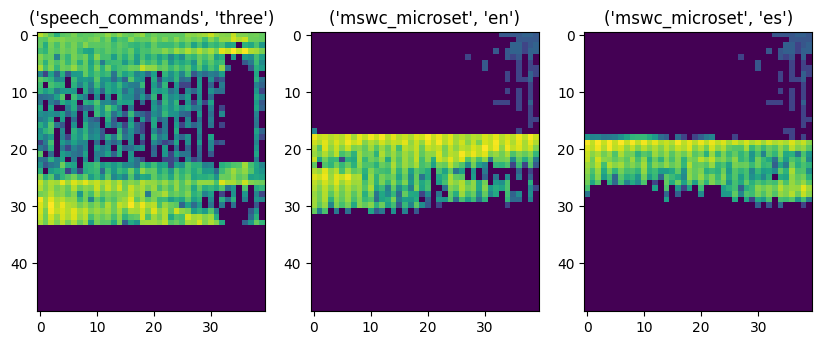

In [27]:
settings = input_data.standard_microspeech_model_settings(label_count=1)
fig,axes = plt.subplots(ncols=3)
for sample, ax in zip([three_gsc[0], three_mswc_en[0], three_mswc_es[0]], axes):
    spectrogram = input_data.file2spec(settings, str(sample)) # PosixPath not supported
    ax.imshow(spectrogram.numpy())
    ax.set_title(sample.parts[:2])
fig.set_size_inches(10,5)

Let's also look at the properties of our converted MSWC `.wav` files. Note that they're all 16KHz and exactly 1 second long, conforming to our expected network inputs below.

In [28]:
print(subprocess.check_output(["soxi", three_mswc_es[0]]).decode("utf8"))


Input File     : 'mswc_microset/es/clips/tres/common_voice_es_18797437.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:01.00 = 16000 samples ~ 75 CDDA sectors
File Size      : 32.0k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM




# Step 3: Train a Keyword Spotting Model
Now let's create an embedding model from the pretrained classification model. To do so, we simply remove the last layer from the classifier.

**Note:** Tensorflow will print a large number of warnings upon loading the model, which can be ignored.

In [ ]:
!tar -xf /content/mswc_microset/mswc_microset.tar.gz -C /content/mswc_microset

In [32]:
import tensorflow as tf

model_path = "./embedding_model/multilingual_context_73_0.8011"

# Load the SavedModel
loaded_model = tf.saved_model.load(model_path)

# Inspect input details
print(loaded_model.signatures['serving_default'].inputs)


[<tf.Tensor 'input_1:0' shape=(None, 49, 40, 1) dtype=float32>, <tf.Tensor 'unknown:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_0:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_1:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_2:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_3:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_4:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_5:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_6:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_7:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_8:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_9:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_10:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_11:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_12:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_13:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_14:0' shape=<unknown> dtype=resource>, <tf.T

In [36]:
import tensorflow as tf

# Load the SavedModel
base_model = tf.saved_model.load("./embedding_model/multilingual_context_73_0.8011")

# Create a custom wrapper layer
class EmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, saved_model_path, **kwargs):
        super().__init__(**kwargs)
        self.saved_model = tf.saved_model.load(saved_model_path)
        self.trainable = False

    def call(self, inputs):
        return self.saved_model(inputs)

# Create the embedding layer
embedding = EmbeddingLayer("./embedding_model/multilingual_context_73_0.8011")

Let us look at an embedding representation for one of our samples above:

Filepath: mswc_microset/en/clips/three/common_voice_en_15680.wav
Spectrogram shape (49, 40)
Feature vector shape: (1, 761)


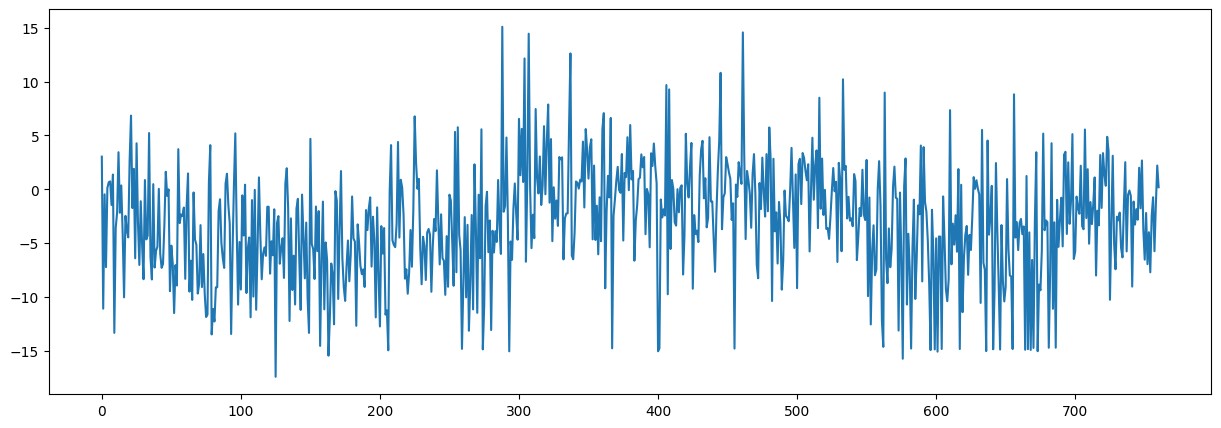

In [38]:
sample_fpath = str(three_mswc_en[0])
print("Filepath:", sample_fpath)
spectrogram = input_data.file2spec(settings, sample_fpath)
print("Spectrogram shape", spectrogram.shape)
# retrieve embedding vector representation (reshape into 1x49x40x1)
feature_vec = embedding(spectrogram[tf.newaxis, :, :, tf.newaxis])

print("Feature vector shape:", feature_vec.shape)
plt.plot(feature_vec[0]);
plt.gcf().set_size_inches(15,5)


# Optional Embedding Visualization
We can look at a 2D projection of the embedding representation for all of the keyword samples in English to see if keywords appear to cluster together (and are separated from other keywords) by using the [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) dimensionality reduction algorithm. This will project each 1024-D feature vector into a 2D space, allowing us to visualize each keyword cluster.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


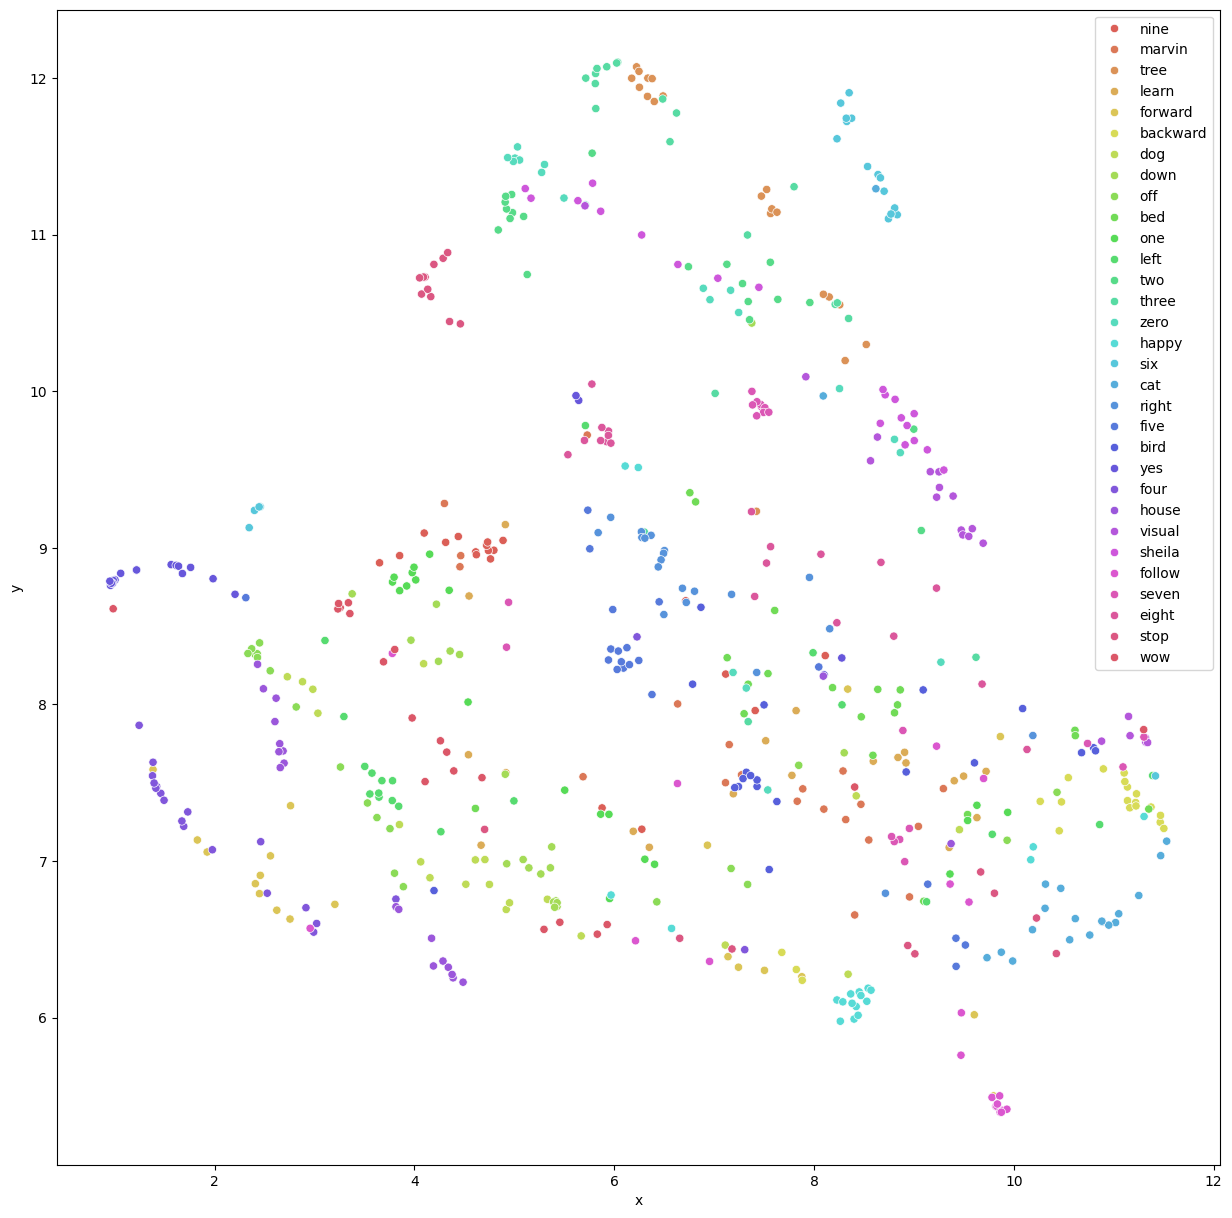

In [43]:
!pip install -q umap-learn
import umap
import pandas as pd
import sklearn.preprocessing
import seaborn as sns
reducer = umap.UMAP()
wavs = list(Path("mswc_microset/en/clips").rglob("*.wav"))
labels = [w.parts[-2] for w in wavs]
spectrograms = np.array([input_data.file2spec(settings, str(w)) for w in wavs])
# Add the channel dimension to spectrograms
spectrograms = np.expand_dims(spectrograms, axis=-1)  # Shape: (620, 49, 40, 1)
embeddings = embedding(spectrograms)

scaled_embeddings = sklearn.preprocessing.StandardScaler().fit_transform(embeddings)
projection = reducer.fit_transform(scaled_embeddings)
df = pd.DataFrame(data=dict(x=projection[:,0], y=projection[:, 1], keyword=labels))
kws = set(df.keyword.tolist())
sns.scatterplot(x="x", y="y", hue=df.keyword.tolist(), data=df, palette=sns.color_palette("hls", n_colors=len(kws)))
plt.gcf().set_size_inches(15,15)

Let us now train a 5-shot model to classify the Spanish keyword "tiempo" (which can mean "time" or "weather" in English).
* First we will convert the remaining samples into `.wav` files.
* Next we will select 5 training examples from the training split.
* We will finetune our embedding model on these 5 examples.
* We will assess our accuracy on the test split, and against a selection of non-target words from MSWC and GSC

If you'd like to instead train a standard keyword spotting model as opposed to a few-shot model, TensorFlow provides an [easy-to-follow tutorial](https://www.tensorflow.org/tutorials/audio/simple_audio) - just replace the GSC dataset with the MSWC dataset or microset (and remember to convert the 48KHz opus files to 16KHz wav files, as above).

In [44]:
# Converting all microset samples of our selected keyword
LANG="es" # ISOCODE for spanish
KEYWORD="tiempo"
src_files = list(Path(f"mswc_microset/mswc_microset/{LANG}/clips/{KEYWORD}").glob("*.opus"))
dest_dir = Path(f"mswc_microset/{LANG}/clips/{KEYWORD}")
for sample in tqdm(src_files):
    dest_file = dest_dir / (sample.stem + ".wav")
    cmd = ["opusdec", "--rate", "16000", sample, dest_file]
    subprocess.run(cmd)

  0%|          | 0/1520 [00:00<?, ?it/s]

In [45]:
# load the training and test splits
splits = {}
with open("mswc_microset/mswc_microset/es/es_splits.csv", "r") as fh:
    reader = csv.reader(fh)
    next(reader) # skip header: SET,LINK,WORD,VALID,SPEAKER,GENDER
    for row in reader:
        if row[2] == KEYWORD:
            wav = Path(row[1]).stem + ".wav"
            splits[wav] = row[0].lower()

all_samples = [str(s) for s in sorted(Path(f"mswc_microset/{LANG}/clips/{KEYWORD}").glob("*.wav"))]
print("# of total samples", len(all_samples))
train_samples = [s for s in all_samples if splits[Path(s).name] == "train"]
print("# of train samples", len(train_samples))
dev_samples = [s for s in all_samples if splits[Path(s).name] == "dev"]
print("# of dev samples", len(dev_samples))
test_samples = [s for s in all_samples if splits[Path(s).name] == "test"]
print("# of test samples", len(test_samples))

# of total samples 1520
# of train samples 1216
# of dev samples 152
# of test samples 152


Let's choose 5 training samples from the training split and listen to them:

In [46]:
rng = np.random.RandomState(0)
five_samples = rng.choice(train_samples, 5, replace=False).tolist()
print(five_samples)
for s in five_samples:
    listen(s)

['mswc_microset/es/clips/tiempo/common_voice_es_20909110.wav', 'mswc_microset/es/clips/tiempo/common_voice_es_18312321.wav', 'mswc_microset/es/clips/tiempo/common_voice_es_20343100.wav', 'mswc_microset/es/clips/tiempo/common_voice_es_20379087.wav', 'mswc_microset/es/clips/tiempo/common_voice_es_19955827.wav']


Now we will train the few-shot model. We will need our set of unknown keywords for this, as well as background noise samples from Google Speech Commands. Again, note that you can ignore any emitted warnings when loading the pretrained classifier.

In [47]:
background_noise = "/content/speech_commands/_background_noise_/"
unknown_files_txt = "/content/unknown_files/unknown_files.txt"
unknown_files=[]
with open(unknown_files_txt, "r") as fh:
    for w in fh.read().splitlines():
        unknown_files.append("/content/unknown_files/" + w)
print("Number of unknown files", len(unknown_files))

print("---Training model---")
model_settings = input_data.standard_microspeech_model_settings(3)
_, model, _ = transfer_learning.transfer_learn(
    target=KEYWORD,
    train_files=five_samples,
    val_files=dev_samples,
    unknown_files=unknown_files,
    num_epochs=4,
    num_batches=1,
    batch_size=64,
    primary_lr=0.001,
    backprop_into_embedding=False,
    embedding_lr=0,
    model_settings=model_settings,
    base_model_path="embedding_model/multilingual_context_73_0.8011",
    base_model_output="dense_2",
    UNKNOWN_PERCENTAGE=50.0,
    bg_datadir=background_noise,
    csvlog_dest=None,
)
model.save(f"{KEYWORD}_5shot")


Number of unknown files 4970
---Training model---


ValueError: File format not supported: filepath=embedding_model/multilingual_context_73_0.8011. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(embedding_model/multilingual_context_73_0.8011, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

Using the 5 examples above for "tiempo" we should correctly classify roughly 90% of our test samples, which is pretty neat for a model trained on only five examples!

Note that the accuracy of a few-shot model can be quite sensitive to the particular samples chosen. A different set of five training samples will likely vary by a few percentage points from this model. The subset of unknown words and background noise also impact accuracy. Furthermore, some of the extracted test samples may be truncated (due to incorrect word boundary estimates) or occasionally anomalous due to issues with the originating crowdsourced data so a more accurate estimate of the test performance can only be made after manually listening to all test samples and discarding any malformed samples.

Please also see [our paper](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/hash/fe131d7f5a6b38b23cc967316c13dae2-Abstract-round2.html) for our self-supervised nearest-neighbor approach to automatically detecting anomalous samples. Our implementation can also be found in the [parent repository](https://github.com/harvard-edge/multilingual_kws).

In [ ]:
test_spectrograms = np.array([input_data.file2spec(settings, f) for f in test_samples])
# fetch softmax predictions from the finetuned model:
# (class 0: silence/background noise, class 1: unknown keyword, class 2: target)
predictions = model.predict(test_spectrograms)
categorical_predictions = np.argmax(predictions, axis=1)
# which predictions match the target class?
accuracy = categorical_predictions[categorical_predictions == 2].shape[0] / predictions.shape[0]
print(f"Test accuracy on testset: {accuracy:0.2f}")

Test accuracy on testset: 0.91


Let's listen to five random correctly-classified examples from the test set:

In [ ]:
sample_idxs = np.random.choice(np.flatnonzero(categorical_predictions == 2), 5, replace=False)
for i in sample_idxs:
    listen(test_samples[i])

and 5 incorrectly-classified examples. These may be a mix of false negatives (true instances of the keyword which were classified incorrectly) and anomalous samples (due to errors in forced alignment or the original crowdsourced data).

In [ ]:
sample_idxs = np.random.choice(np.flatnonzero(categorical_predictions != 2), 5, replace=False)
for i in sample_idxs:
    listen(test_samples[i])

Finally, let's verify that the keyword spotting model correctly categorizes non-target words as "unknown" by selecting the 20 random `.wav` files we converted for each of the remaining subset of keywords in our Spanish microset (in total, 380 samples), and running predictions on their spectrograms. We should observe around 95% of these words are correctly classified as `"unknown"` by our 5-shot model.

In [ ]:
non_target_examples = []
for word in os.listdir(f"mswc_microset/{LANG}/clips"):
    if word == KEYWORD:
        continue
    non_target_examples.extend(Path(f"mswc_microset/{LANG}/clips/{word}").glob("*.wav"))
print("Number of non-target examples", len(non_target_examples))

non_target_spectrograms = np.array([input_data.file2spec(settings, str(f)) for f in non_target_examples])
# fetch softmax predictions from the finetuned model:
# (class 0: silence/background noise, class 1: unknown keyword, class 2: target)
predictions = model.predict(non_target_spectrograms)
categorical_predictions = np.argmax(predictions, axis=1)
# which predictions match the non-target class?
accuracy = categorical_predictions[categorical_predictions == 1].shape[0] / predictions.shape[0]
print(f"Estimated accuracy on non-target samples: {accuracy:0.2f}")

Number of non-target examples 380
Estimated accuracy on non-target samples: 0.95


# Next Steps

We provide a [Docker container](https://github.com/harvard-edge/multilingual_kws/blob/99b82c459de09c7d4ac59e601c1ac5cc283cce85/docker/Dockerfile) which invokes our [training + inference script](https://github.com/harvard-edge/multilingual_kws/blob/99b82c459de09c7d4ac59e601c1ac5cc283cce85/multilingual_kws/run.py) in order to train, evaluate, and interactively visualize results for running few-shot keyword spotting models on continuous audio.


> ![kwsviz.png](https://github.com/harvard-edge/multilingual_kws/raw/main/images/web_frontend.png)


# The MSWC Dataset

The full dataset for the Multilingual Spoken Words Corpus can be downloaded [here](https://mlcommons.org/words):

https://mlcommons.org/en/multilingual-spoken-words

You can also join our mailing list and Discord server from there.

Compared to the 51 words contained in our microset, there are over 38,000 words in English and over 24,000 words in Spanish in the full MSWC dataset.

The full set of 50 languages in Version 1 of MSWC is:

> Arabic, Assamese, Basque, Breton, Catalan, Chinese, Chuvash, Czech, Dhivehi, Dutch, English, Esparanto, Estonian, French, Frisian, Georgian, German, Greek, Guarani, Hakha Chin, Hausa, Indonesian, Interlingua, Irish, Italian, Kinyarwada, Kyrgyz, Latvian, Lithuanian, Maltese, Mongolian, Oriya, Persian, Polish, Portuguese, Romanian, Russian, Sakha, Slovak, Slovenian, Spanish, Sursilvan, Swedish, Tamil, Tatar, Turkish, Ukranian, Vallader, Vietnamese, and Welsh

Please see [our paper](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/hash/fe131d7f5a6b38b23cc967316c13dae2-Abstract-round2.html) for details.

MSWC will expand to include additional languages and more words within each language in future versions. We hope you will find our dataset useful in your research or commercial applications.
